# Data preparation

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import utils
from keras import backend as keras
from tensorflow.keras.preprocessing.image import load_img
import random
import warnings


random.seed(42)
np.random.seed(42)
utils.set_random_seed(42)
warnings.filterwarnings('ignore')

In [ ]:
# Встановлення бібліотеки kaggle
!pip install kaggle

# Створення папки .kaggle і переміщення kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Зміна прав доступу для kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# Завантаження датасету
!kaggle datasets download -d bulentsiyah/semantic-drone-dataset

# Розпакування завантаженого архіву
!unzip semantic-drone-dataset.zip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/bulentsiyah/semantic-drone-dataset
License(s): other
 99% 3.87G/3.89G [00:51<00:00, 71.7MB/s]
100% 3.89G/3.89G [00:51<00:00, 80.4MB/s]
Archive:  semantic-drone-dataset.zip
  inflating: RGB_color_image_masks/RGB_color_image_masks/000.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/001.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/002.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/003.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/004.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/005.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/006.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/008.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/011.png  
  inflating: RGB_color_image_masks/RGB_color_im

In [ ]:
!ls
!ls 'dataset/semantic_drone_dataset'

class_dict_seg.csv  dataset  RGB_color_image_masks  sample_data  semantic-drone-dataset.zip
label_images_semantic  original_images


In [ ]:
data_path = ''
org_imgs_path = os.path.join(data_path, 'dataset/semantic_drone_dataset/original_images')
masks_path = os.path.join(data_path, 'RGB_color_image_masks', 'RGB_color_image_masks')
print(f"Numper of images: {len(os.listdir(org_imgs_path))}")
print(f"Numper of masks: {len(os.listdir(masks_path))}")

Numper of images: 400
Numper of masks: 400


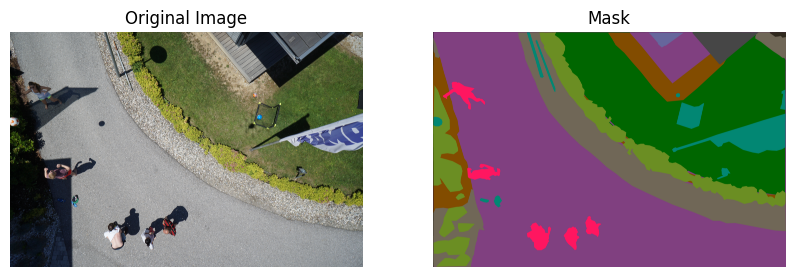

In [ ]:
image_name = os.listdir(org_imgs_path)[0]
org_img = cv2.imread(os.path.join(org_imgs_path, image_name))
org_img = cv2.cvtColor(org_img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(os.path.join(masks_path, image_name.replace('.jpg', '.png')))
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(org_img)
plt.axis('off')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.axis('off')
plt.title('Mask')
plt.show()

In [ ]:
csv_path = os.path.join(data_path, 'class_dict_seg.csv')
classes = pd.read_csv(csv_path)
classes

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


In [ ]:
n_classes = len(classes)
n_classes

24

In [ ]:
#A dictionary mapping class names to RGB values
cls2rgb = {cl:list(values) for cl, values in zip(classes['name'], classes.iloc[:,1:].values)}
cls2rgb

{'unlabeled': [0, 0, 0],
 'paved-area': [128, 64, 128],
 'dirt': [130, 76, 0],
 'grass': [0, 102, 0],
 'gravel': [112, 103, 87],
 'water': [28, 42, 168],
 'rocks': [48, 41, 30],
 'pool': [0, 50, 89],
 'vegetation': [107, 142, 35],
 'roof': [70, 70, 70],
 'wall': [102, 102, 156],
 'window': [254, 228, 12],
 'door': [254, 148, 12],
 'fence': [190, 153, 153],
 'fence-pole': [153, 153, 153],
 'person': [255, 22, 96],
 'dog': [102, 51, 0],
 'car': [9, 143, 150],
 'bicycle': [119, 11, 32],
 'tree': [51, 51, 0],
 'bald-tree': [190, 250, 190],
 'ar-marker': [112, 150, 146],
 'obstacle': [2, 135, 115],
 'conflicting': [255, 0, 0]}

In [ ]:
def adjust_mask(mask, flat=False):

    semantic_map = []
    for colour in list(cls2rgb.values()):
        equality = np.equal(mask, colour)# 256x256x3 with True or False
        class_map = np.all(equality, axis = -1)# 256x256 If all True, then True, else False
        semantic_map.append(class_map)# List of 256x256 arrays, map of True for a given found color at the pixel, and False otherwise.
    semantic_map = np.stack(semantic_map, axis=-1)# 256x256x32 True only at the found color, and all False otherwise.
    if flat:
        semantic_map = np.reshape(semantic_map, (-1,256*256))

    return np.float32(semantic_map)# convert to numbers

In [ ]:
org_img.shape


(4000, 6000, 3)

In [ ]:
mask.shape

(4000, 6000, 3)

In [ ]:
new_mask = adjust_mask(mask)
new_mask.shape

(4000, 6000, 24)

In [ ]:
#A dictionary mapping class indices to RGB values.
idx2rgb={idx:np.array(rgb) for idx, (cl, rgb) in enumerate(cls2rgb.items())}
idx2rgb

{0: array([0, 0, 0]),
 1: array([128,  64, 128]),
 2: array([130,  76,   0]),
 3: array([  0, 102,   0]),
 4: array([112, 103,  87]),
 5: array([ 28,  42, 168]),
 6: array([48, 41, 30]),
 7: array([ 0, 50, 89]),
 8: array([107, 142,  35]),
 9: array([70, 70, 70]),
 10: array([102, 102, 156]),
 11: array([254, 228,  12]),
 12: array([254, 148,  12]),
 13: array([190, 153, 153]),
 14: array([153, 153, 153]),
 15: array([255,  22,  96]),
 16: array([102,  51,   0]),
 17: array([  9, 143, 150]),
 18: array([119,  11,  32]),
 19: array([51, 51,  0]),
 20: array([190, 250, 190]),
 21: array([112, 150, 146]),
 22: array([  2, 135, 115]),
 23: array([255,   0,   0])}

In [ ]:
def map_class_to_rgb(p):

    return idx2rgb[p[0]]

rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(new_mask, axis=-1), -1))
rgb_mask.shape

(4000, 6000, 3)

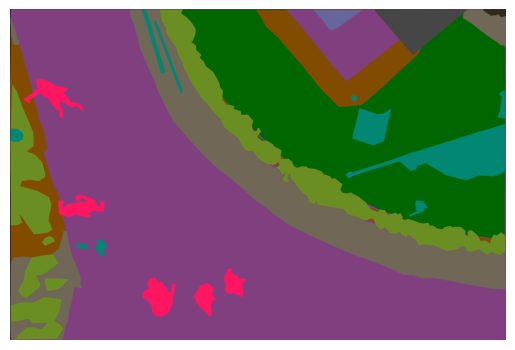

In [ ]:
plt.imshow(rgb_mask)
plt.axis('off')
plt.show()

In [ ]:
rgb_mask = 0
new_mask = 0
org_img = 0
mask = 0

imgs_name = [path.replace('.jpg', '') for path in os.listdir(org_imgs_path)]

for img_name in imgs_name:
    if not os.path.exists(os.path.join(masks_path, img_name+'.png')):
        print(img_name)
    if not os.path.exists(os.path.join(org_imgs_path, img_name+'.jpg')):
        print(img_name)

In [ ]:
data_gen_args = dict(rescale=1./255,
                    validation_split = 0.2)
mask_gen_args = dict(validation_split = 0.2)
seed = 1
batch_sz = 4

In [ ]:
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen  = ImageDataGenerator(**mask_gen_args)

In [ ]:
imgs_path = 'dataset/semantic_drone_dataset'
masks_path = 'RGB_color_image_masks'

image_generator = image_datagen.flow_from_directory(
    imgs_path,
    class_mode=None,
    classes=['original_images'],
    seed=seed,
    batch_size=batch_sz,
    target_size=(256,256),
    subset='training')

mask_generator = mask_datagen.flow_from_directory(
    masks_path,
    classes=['RGB_color_image_masks'],
    class_mode=None,
    seed=seed,
    color_mode='rgb',
    batch_size=batch_sz,
    target_size=(256,256),
    subset='training')

train_generator = zip(image_generator, mask_generator)

val_image_generator = image_datagen.flow_from_directory(
    imgs_path,
    class_mode=None,
    classes=['original_images'],
    seed=seed,
    batch_size=batch_sz,
    target_size=(256,256),
    subset='validation')

val_mask_generator = mask_datagen.flow_from_directory(
    masks_path,
    classes=['RGB_color_image_masks'],
    class_mode=None,
    seed=seed,
    color_mode='rgb',
    batch_size=batch_sz,
    target_size=(256,256),
    subset='validation')

val_generator = zip(val_image_generator, val_mask_generator)

Found 320 images belonging to 1 classes.
Found 320 images belonging to 1 classes.
Found 80 images belonging to 1 classes.
Found 80 images belonging to 1 classes.


In [ ]:
n_train_samples = 320
n_test_samples = 80

In [ ]:
def val_generator_fn():

    for (img,mask) in val_generator:
        new_mask = adjust_mask(mask)
        yield (img,new_mask)

In [ ]:
def train_generator_fn():

    for (img,mask) in train_generator:
        new_mask = adjust_mask(mask)
        yield (img,new_mask)

In [ ]:
x, y = next(train_generator_fn())
x.shape, y.shape

((4, 256, 256, 3), (4, 256, 256, 24))

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np
import albumentations as A

imgs_path = 'dataset/semantic_drone_dataset/original_images'
masks_path = 'RGB_color_image_masks/RGB_color_image_masks'


class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_size=256, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_size = img_size
        self.image_transform = image_transform
        self.mask_transform = mask_transform

        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('RGB')

        if self.image_transform:
            image = self.image_transform(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)

        mask = np.array(mask)
        mask = np.transpose(mask, (1, 2, 0))
        mask = adjust_mask(mask)

        # image = np.array(image)
        # image = image / 255.0

        mask = torch.tensor(mask).permute(2, 0, 1)
        # image = torch.tensor(image, dtype=torch.float32)

        return image, mask

image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Lambda(lambda img: torch.clamp(img, min=0.0, max=1.0)),
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset = SegmentationDataset(imgs_path, masks_path, image_transform=image_transform, mask_transform=mask_transform)

train_size = int(0.80 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

-----------------------------------------------------------------------------

# Навчання згорткових нейронних мереж для Semantic Segmentation

### 1. Вибрати функцію чи декілька для оцінки продуктивності вашої моделі (metrics)

Метрики для сегментаційних задач відрізняються від метрик для класифікації, оскільки важливо оцінити точність класифікації кожного пікселя.

* IoU (Intersection over Union): Це одна з основних метрик для задач сегментації. IoU обчислює співвідношення між перетином та об’єднанням областей, які модель передбачила, і реальними ділянками на зображенні. IoU = TP / (TP + FP + FN)

Ця метрика є надійним показником якості сегментації, оскільки вона враховує як правильно передбачені пікселі, так і ті, що модель не розпізнала або неправильно позначила.

* Dice Coefficient (Dice Similarity Coefficient): Метрика Dice схожа на IoU, але більше акцентує на області збігу передбачених і фактичних областей. Її також можна представити як
Dice = 2TP / (2TP + FP + FN)

Dice також є поширеною метрикою для сегментації, оскільки вона добре підходить для випадків, де є дисбаланс між класами (наприклад, мало передбачуваних пікселів порівняно з загальним розміром зображення).

Метрики IoU і Dice Coefficient дають комплексну оцінку накладання між передбаченими та реальними сегментованими ділянками. Вони є стандартом для сегментації і добре підходять для задач, де критично важливо розуміти, наскільки точно модель розпізнає цільові об'єкти (в цьому випадку, ділянки лісу).

### 2. Вибрати функцію чи декілька для оцінки втрат моделі під час навчання


* Dice Loss: Функція Dice Loss обернена до коефіцієнта Dice. Вона є корисною при сегментації, особливо коли класи сильно дисбалансовані. Dice Loss підсилює модель до більш точного передбачення пікселів, що належать до класу "ліс", зменшуючи вплив фонових пікселів.

* Jaccard Loss: Ще один варіант, який є оберненим до IoU. Jaccard Loss допомагає покращити накладання областей і також добре підходить для сегментації.

# AlexNet

AlexNet with full encoding and decoding

Оригінальна AlexNet використовувала кілька згорткових шарів з великим числом фільтрів для поступового витягання складних ознак. У нашій моделі також є п’ять згорткових шарів (в енкодері), що імітують принцип поступового зростання кількості каналів, схожий на AlexNet.

В AlexNet було вперше показано, що використання функції активації ReLU (Rectified Linear Unit) значно покращує збіжність моделі порівняно з традиційними нелінійностями, такими як сигмоїда. У цій моделі ReLU використовується після кожного згорткового шару для додавання нелінійності.

In [ ]:
# Повний енкодер-декодер для сегментації зображень

import torch
import torch.nn as nn
import torch.nn.functional as F

# Клас AlexNetSegmentation: мережа для піксельної сегментації з використанням архітектури енкодера-декодера
class AlexNetSegmentation(nn.Module):
    def __init__(self, num_classes=24):
        """
        Ініціалізує нейронну мережу для сегментації зображень.

        Параметри:
        num_classes (int): Кількість класів, які ми хочемо сегментувати.
                           Наприклад, 24 означає, що кожен піксель буде віднесений до одного з 24 класів.
        """
        super(AlexNetSegmentation, self).__init__()

        # Енкодер (Feature Extractor - екстрактор ознак)
        # Енкодер зменшує розмірність зображення та знаходить більш абстрактні ознаки
        self.conv1 = nn.Conv2d(3, 24, kernel_size=5, stride=2, padding=2)  # Перший шар: з 3 (RGB) каналів в 24
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # Перший пулінг для зменшення розмірності
        self.conv2 = nn.Conv2d(24, 96, kernel_size=3, padding=1)  # Другий шар: з 24 каналів у 96
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # Другий пулінг
        self.conv3 = nn.Conv2d(96, 128, kernel_size=3, padding=1)  # Третій шар: з 96 у 128 каналів
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)  # Четвертий шар: 128 у 128
        self.conv5 = nn.Conv2d(128, 64, kernel_size=3, padding=1)  # П’ятий шар: з 128 у 64
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # Третій пулінг

        # Декодер (Upsampling layers - шари для відновлення розмірів)
        # Декодер повертає просторову розмірність зображення (піксель за пікселем)
        self.conv_up1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Шар розгортання: 64 у 128 каналів
        self.conv_up2 = nn.Conv2d(128, 96, kernel_size=3, padding=1)  # Шар розгортання: 128 у 96
        self.conv_up3 = nn.Conv2d(96, 64, kernel_size=3, padding=1)  # Шар розгортання: 96 у 64
        self.conv_up4 = nn.Conv2d(64, num_classes, kernel_size=1)  # Вихідний шар: 64 у num_classes (24)

    def forward(self, x):
        """
        Визначає прямий прохід через мережу.

        Параметри:
        x (torch.Tensor): Вхідне зображення у форматі (batch_size, channels, height, width)

        Повертає:
        torch.Tensor: Вихідний сегментований результат у форматі (batch_size, num_classes, height, width)
        """
        # Енкодер (стиснення просторової інформації)
        x = F.relu(self.conv1(x))  # Активація ReLU після першого згорткового шару
        x = self.pool1(x)  # Перший пулінг зменшує просторову розмірність
        x = F.relu(self.conv2(x))  # Другий згортковий шар з активацією ReLU
        x = self.pool2(x)  # Другий пулінг
        x = F.relu(self.conv3(x))  # Третій згортковий шар
        x = F.relu(self.conv4(x))  # Четвертий згортковий шар
        x = F.relu(self.conv5(x))  # П’ятий згортковий шар
        x = self.pool3(x)  # Третій пулінг

        # Декодер (відновлення просторової інформації)
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)  # Удвоєння розміру
        x = F.relu(self.conv_up1(x))  # Згортання після першого збільшення
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)  # Ще одне удвоєння розміру
        x = F.relu(self.conv_up2(x))  # Згортання після другого збільшення
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)  # Ще одне удвоєння
        x = F.relu(self.conv_up3(x))  # Згортання після третього збільшення
        x = F.interpolate(x, size=(256, 256), mode='bilinear', align_corners=False)  # Встановлення розміру 256x256
        x = self.conv_up4(x)  # Фінальний згортковий шар, щоб отримати num_classes каналів (по одному на клас)

        return x


In [ ]:
from torchsummary import summary

input_size = (3, 256, 256)

segm_model = AlexNetSegmentation(num_classes=24).to(device)

summary(segm_model, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 128, 128]           1,824
         MaxPool2d-2           [-1, 24, 64, 64]               0
            Conv2d-3           [-1, 96, 64, 64]          20,832
         MaxPool2d-4           [-1, 96, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]         110,720
            Conv2d-6          [-1, 128, 32, 32]         147,584
            Conv2d-7           [-1, 64, 32, 32]          73,792
         MaxPool2d-8           [-1, 64, 16, 16]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
           Conv2d-10           [-1, 96, 64, 64]         110,688
           Conv2d-11         [-1, 64, 128, 128]          55,360
           Conv2d-12         [-1, 24, 256, 256]           1,560
Total params: 596,216
Trainable params: 596,216
Non-trainable params: 0
-------------------------------

In [ ]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(output, dim=1)
        correct = (output == mask).float()
        acc = correct.sum() / correct.numel()
    return acc

def mean_iou(output, mask, num_classes):
    with torch.no_grad():
        output = torch.argmax(output, dim=1)
        iou_per_class = []
        for cls in range(num_classes):
            true_class = (mask == cls)
            pred_class = (output == cls)
            intersection = (pred_class & true_class).sum().float()
            union = (pred_class | true_class).sum().float()
            if union == 0:
                iou = torch.nan
            else:
                iou = intersection / union
            iou_per_class.append(iou)
        mean_iou = torch.nanmean(torch.stack(iou_per_class))
    return mean_iou

num_classes = 24
batch_size = 8
learning_rate = 1e-4
num_epochs = 20

In [ ]:
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
segm_model = AlexNetSegmentation(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(segm_model.parameters(), lr=learning_rate)

In [ ]:
def normalize_rgb(mask_rgb, idx2rgb_values):

    min_dist = float('inf')
    closest_rgb = None
    for rgb in idx2rgb_values:
        dist = np.linalg.norm(mask_rgb - rgb)  # Euclidean distance
        if dist < min_dist:
            min_dist = dist
            closest_rgb = rgb
    return closest_rgb

def adjust_mask(mask):

    semantic_map = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int64)
    idx2rgb_values = list(idx2rgb.values())

    # Normalize each pixel to the closest RGB value
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            normalized_rgb = normalize_rgb(mask[i, j], idx2rgb_values)
            mask[i, j] = normalized_rgb

    for idx, rgb in idx2rgb.items():
        matches = np.all(mask == rgb, axis=-1)
        semantic_map[matches] = idx

    return semantic_map


In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np
import albumentations as A

imgs_path = 'dataset/semantic_drone_dataset/original_images'
masks_path = 'RGB_color_image_masks/RGB_color_image_masks'


class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_size=256, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_size = img_size
        self.image_transform = image_transform
        self.mask_transform = mask_transform

        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
       img_path = os.path.join(self.image_dir, self.image_files[idx])
       mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

       image = Image.open(img_path).convert('RGB')
       mask = Image.open(mask_path).convert('RGB')

       if self.image_transform:
           image = self.image_transform(image)

       if self.mask_transform:
           mask = self.mask_transform(mask)

       mask = np.array(mask)
       mask = np.transpose(mask, (1, 2, 0))
       mask = adjust_mask(mask)
       mask = torch.tensor(mask, dtype=torch.long)

       return image, mask


image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Lambda(lambda img: torch.clamp(img, min=0.0, max=1.0)),
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset = SegmentationDataset(imgs_path, masks_path, image_transform=image_transform, mask_transform=mask_transform)

train_size = int(0.80 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        if outputs.size()[2:] != masks.size()[1:]:
            masks = F.interpolate(masks.unsqueeze(1).float(), size=outputs.shape[2:], mode='nearest').squeeze(1).long()

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Епоха {epoch+1}/{num_epochs}, Втрата на тренуванні: {epoch_loss:.4f}")

    model.eval()
    val_loss = 0.0
    total_acc = 0.0
    total_iou = 0.0
    with torch.no_grad():
        for val_images, val_masks in val_loader:
            val_images = val_images.to(device)
            val_masks = val_masks.to(device)

            outputs = model(val_images)

            if outputs.size()[2:] != val_masks.size()[1:]:
                val_masks = F.interpolate(val_masks.unsqueeze(1).float(), size=outputs.shape[2:], mode='nearest').squeeze(1).long()

            loss = criterion(outputs, val_masks)
            val_loss += loss.item() * val_images.size(0)

            # Обчислення метрик
            acc = pixel_accuracy(outputs, val_masks)
            miou = mean_iou(outputs, val_masks, num_classes=num_classes)
            total_acc += acc.item() * val_images.size(0)
            total_iou += miou.item() * val_images.size(0)

    val_epoch_loss = val_loss / len(val_loader.dataset)
    val_epoch_acc = total_acc / len(val_loader.dataset)
    val_epoch_iou = total_iou / len(val_loader.dataset)
    print(f"Епоха {epoch+1}/{num_epochs}, Втрата на валідації: {val_epoch_loss:.4f}, Точність: {val_epoch_acc:.4f}, mIoU: {val_epoch_iou:.4f}")

torch.save(model.state_dict(), 'alexnet_segmentation_model.pth')

model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        images = images.cpu().permute(0, 2, 3, 1).numpy()
        masks = masks.cpu().numpy()
        preds = preds.cpu().numpy()

        idx = 0
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(images[idx])
        plt.title('Вхідне зображення')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        mask_rgb = np.apply_along_axis(lambda p: idx2rgb[p[0]], -1, np.expand_dims(masks[idx], -1))
        plt.imshow(mask_rgb.astype(np.uint8))
        plt.title('Справжня маска')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        pred_rgb = np.apply_along_axis(lambda p: idx2rgb[p[0]], -1, np.expand_dims(preds[idx], -1))
        plt.imshow(pred_rgb.astype(np.uint8))
        plt.title('Передбачена маска')
        plt.axis('off')

        plt.show()
        break

In [ ]:
def extract_features(model, data_loader, num_samples=100000):
    """
    Функція для витягнення ознак (features) та відповідних міток (labels) з моделі сегментації зображень.

    Параметри:
    -----------
    model : torch.nn.Module
        Модель сегментації, яка використовується для екстракції ознак.
    data_loader : DataLoader
        Пітормічний DataLoader, який ітерує зображення та маски (ground truth).
    num_samples : int
        Максимальна кількість вибірок (пікселів), які будуть відібрані з даних.

    Повертає:
    --------
    features_all : numpy.ndarray
        Масив ознак розміром `(num_samples, num_channels)`.
        Кожен рядок відповідає вектору ознак для одного пікселя.
    labels_all : numpy.ndarray
        Масив міток розміром `(num_samples,)`.
        Кожен елемент відповідає класу для відповідного пікселя.
    """
    # Списки для збереження відібраних ознак і міток
    features_list = []
    labels_list = []
    total_samples = 0  # Лічильник загальної кількості відібраних пікселів

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model.eval()  # Встановлюємо модель у режим оцінювання (без оновлення ваг)

    with torch.no_grad():
        for img_batch, mask_batch in data_loader:
            img_batch = torch.tensor(img_batch, dtype=torch.float32).to(device)
            mask_batch = torch.tensor(mask_batch, dtype=torch.long).to(device)

            # Переміщуємо осі для відповідності формату PyTorch (N, C, H, W)
            img_batch = img_batch.permute(0, 3, 1, 2)  # Вхідні зображення
            mask_batch = mask_batch.permute(0, 3, 1, 2)  # Маски

            # Прямий прохід через модель, отримуємо карти ознак (feature maps)
            feature_maps = model(img_batch)

            # Ресайзимо маски для відповідності розмірам карт ознак
            fm_height = feature_maps.shape[2]
            fm_width = feature_maps.shape[3]
            mask_resized = F.interpolate(
                mask_batch.float(),  # Маски мають бути у форматі float для інтерполяції
                size=(fm_height, fm_width),  # Нові розміри
                mode='nearest'
            ).long()

            # Розплющуємо ознаки та мітки для спрощення роботи з ними
            batch_size = feature_maps.shape[0]
            num_pixels = fm_height * fm_width  # Кількість пікселів у карті ознак
            num_channels = feature_maps.shape[1]  # Кількість каналів (ознак)
            features = feature_maps.permute(0, 2, 3, 1).reshape((batch_size * num_pixels, num_channels))
            labels = mask_resized.permute(0, 2, 3, 1).reshape((batch_size * num_pixels, -1))

            # Перетворюємо one-hot маски у мітки класів (наприклад, [0, 1, 0] -> 1)
            labels = torch.argmax(labels, dim=-1)

            # Вибираємо випадкові пікселі з усієї карти ознак
            indices = torch.randperm(features.shape[0])[:min(num_samples - total_samples, features.shape[0])]
            features_sampled = features[indices]  # Вибрані ознаки
            labels_sampled = labels[indices]  # Вибрані мітки

            # Додаємо вибрані дані до списків
            features_list.append(features_sampled.cpu().numpy())
            labels_list.append(labels_sampled.cpu().numpy())
            total_samples += len(indices)  # Оновлюємо лічильник

            # Якщо кількість вибраних пікселів досягла ліміту, припиняємо цикл
            if total_samples >= num_samples:
                break

    features_all = np.concatenate(features_list, axis=0)
    labels_all = np.concatenate(labels_list, axis=0)
    return features_all, labels_all


In [ ]:
train_data_loader = train_generator_fn()

In [ ]:
features, labels = extract_features(segm_model, train_data_loader)

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)


Feature maps shape: torch.Size([4, 24, 256, 256])
Mask batch shape: torch.Size([4, 24, 256, 256])
Features shape: (100000, 24)
Labels shape: (100000,)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

knn_classifier = KNeighborsClassifier(n_neighbors=5)

knn_classifier.fit(X_train, y_train)


KNeighborsClassifier()

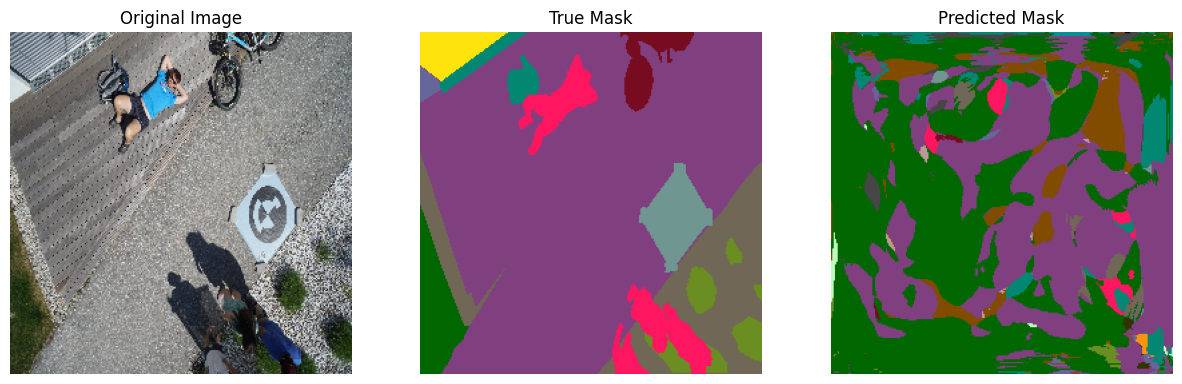

In [ ]:
def predict_segmentation(model, classifier, img):


    # Конвертуємо зображення у тензор PyTorch:
    # - .permute(2, 0, 1): змінюємо порядок осей із (H, W, C) на (C, H, W) для PyTorch.
    # - .unsqueeze(0): додаємо вимір для batch, формуючи (1, C, H, W).
    img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    img_tensor = img_tensor.to(device)

    # Прогнозуємо карти ознак (feature maps) без обчислення градієнтів (економія пам’яті та часу).
    with torch.no_grad():
        feature_map = model(img_tensor)  # Вихід: (1, C, H_fm, W_fm)

    # Перетворюємо карту ознак у формат NumPy та видаляємо вимір batch:
    # - .cpu(): переміщуємо дані на CPU.
    # - .numpy(): конвертуємо тензор у масив NumPy.
    # - .squeeze(0): видаляємо вимір batch, отримуємо (C, H_fm, W_fm).
    feature_map = feature_map.cpu().numpy().squeeze(0)

    # Розпаковуємо розміри карти ознак:
    # - num_channels (C): кількість каналів ознак.
    # - fm_height (H_fm), fm_width (W_fm): просторові розміри карти ознак.
    num_channels, fm_height, fm_width = feature_map.shape

    # Розплющуємо карту ознак у формат (H_fm * W_fm, C) для класифікатора:
    # - .reshape: змінюємо форму на (C, H_fm * W_fm).
    # - .T: транспонуємо для отримання (H_fm * W_fm, C), де кожен рядок - це ознаки одного пікселя.
    features = feature_map.reshape((num_channels, fm_height * fm_width)).T

    # Використовуємо класифікатор для передбачення класу кожного пікселя:
    # - .predict: передбачає мітки для кожного ряду (пікселя).
    # - Вихід: (H_fm * W_fm,).
    predicted_labels = classifier.predict(features)

    # Повертаємо передбачені мітки у форму (H_fm, W_fm), щоб відповідати розміру карти ознак.
    predicted_labels = predicted_labels.reshape((fm_height, fm_width))

    # Змінюємо розмір передбаченої маски до розмірів оригінального зображення (256x256):
    # - .unsqueeze(0).unsqueeze(0): додаємо batch і channel для PyTorch.
    # - torch.nn.functional.interpolate: змінює розміри маски з (H_fm, W_fm) до (256, 256).
    # - .squeeze(): видаляємо додані виміри.
    # - .numpy(): конвертуємо в NumPy для подальшої обробки.
    predicted_labels_resized = torch.nn.functional.interpolate(
        torch.tensor(predicted_labels, dtype=torch.float32).unsqueeze(0).unsqueeze(0),
        size=(256, 256),
        mode='nearest'
    ).squeeze().numpy().astype(int)

    return predicted_labels_resized



val_img_batch, val_mask_batch = next(val_generator_fn())
val_img = val_img_batch[0]
val_mask = val_mask_batch[0]

predicted_mask = predict_segmentation(segm_model, knn_classifier, val_img)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(val_img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
true_mask_rgb = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(val_mask, axis=-1), -1))
plt.imshow(true_mask_rgb.astype(np.uint8))
plt.title("True Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
predicted_mask_one_hot = np.eye(n_classes)[predicted_mask]
predicted_mask_rgb = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(predicted_mask, axis=-1))
plt.imshow(predicted_mask_rgb.astype(np.uint8))
plt.title("Predicted Mask")
plt.axis('off')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D
)
from tensorflow.keras.models import Model



def AlexNet_FeatureExtractor(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)
    # Layer 1
    x = Conv2D(96, kernel_size=11, strides=4, padding='valid', name='conv1')(inputs)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)
    # Layer 2
    x = Conv2D(256, kernel_size=5, strides=1, padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)
    # Layer 3
    x = Conv2D(384, kernel_size=3, strides=1, padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    # Layer 4
    x = Conv2D(384, kernel_size=3, strides=1, padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    # Layer 5
    x = Conv2D(256, kernel_size=3, strides=1, padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)

    # feature map
    model = Model(inputs=inputs, outputs=x)
    return model



In [ ]:
alexnet_model = AlexNet_FeatureExtractor(input_shape=(256, 256, 3))

alexnet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 62, 62, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn1 (BatchNormalization)             │ (None, 62, 62, 96)          │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 62, 62, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 30, 30, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 30, 30, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn2 (BatchNormalization)             │ (None, 30, 30, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 14, 14, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn3 (BatchNormalization)             │ (None, 14, 14, 384)         │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 14, 14, 384)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4 (Conv2D)                       │ (None, 14, 14, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn4 (BatchNormalization)             │ (None, 14, 14, 384)         │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 14, 14, 384)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv5 (Conv2D)                       │ (None, 14, 14, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn5 (BatchNormalization)             │ (None, 14, 14, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 14, 14, 256)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,752,704 (14.32 MB)

 Trainable params: 3,749,952 (14.30 MB)

 Non-trainable params: 2,752 (10.75 KB)

In [ ]:
import numpy as np
from tensorflow.image import resize

def extract_features(model, data_loader, num_samples=100000):
    features_list = []
    labels_list = []
    total_samples = 0

    for img_batch, mask_batch in data_loader:

        feature_maps = model.predict(img_batch)

        fm_height = feature_maps.shape[1]
        fm_width = feature_maps.shape[2]

        mask_resized = tf.image.resize(mask_batch, (fm_height, fm_width), method='nearest').numpy()

        mask_resized = np.round(mask_resized).astype(int)

        batch_size = feature_maps.shape[0]
        num_pixels = fm_height * fm_width
        num_channels = feature_maps.shape[-1]
        features = feature_maps.reshape((batch_size * num_pixels, num_channels))
        labels = mask_resized.reshape((batch_size * num_pixels, mask_batch.shape[-1]))
        labels = np.argmax(labels, axis=-1)

        indices = np.random.choice(features.shape[0], size=min(num_samples - total_samples, features.shape[0]), replace=False)
        features_sampled = features[indices]
        labels_sampled = labels[indices]

        features_list.append(features_sampled)
        labels_list.append(labels_sampled)
        total_samples += len(indices)

        if total_samples >= num_samples:
            break

    features_all = np.concatenate(features_list, axis=0)
    labels_all = np.concatenate(labels_list, axis=0)
    return features_all, labels_all

In [ ]:
def predict_segmentation(model, classifier, img):

    img = np.expand_dims(img, axis=0)

    feature_map = model.predict(img)
    fm_height, fm_width, num_channels = feature_map.shape[1], feature_map.shape[2], feature_map.shape[3]

    features = feature_map.reshape((fm_height * fm_width, num_channels))

    predicted_labels = classifier.predict(features)

    predicted_labels = predicted_labels.reshape((fm_height, fm_width))

    predicted_labels_resized = tf.image.resize(np.expand_dims(predicted_labels, axis=-1), (256, 256), method='nearest').numpy().squeeze().astype(int)
    return predicted_labels



val_img_batch, val_mask_batch = next(val_generator_fn())
val_img = val_img_batch[0]
val_mask = val_mask_batch[0]

predicted_mask = predict_segmentation(alexnet_model, knn_classifier, val_img)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(val_img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
true_mask_rgb = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(val_mask, axis=-1), -1))
plt.imshow(true_mask_rgb.astype(np.uint8))
plt.title("True Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
predicted_mask_one_hot = np.eye(n_classes)[predicted_mask]
predicted_mask_rgb = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(predicted_mask, axis=-1))
plt.imshow(predicted_mask_rgb.astype(np.uint8))
plt.title("Predicted Mask")
plt.axis('off')
plt.show()


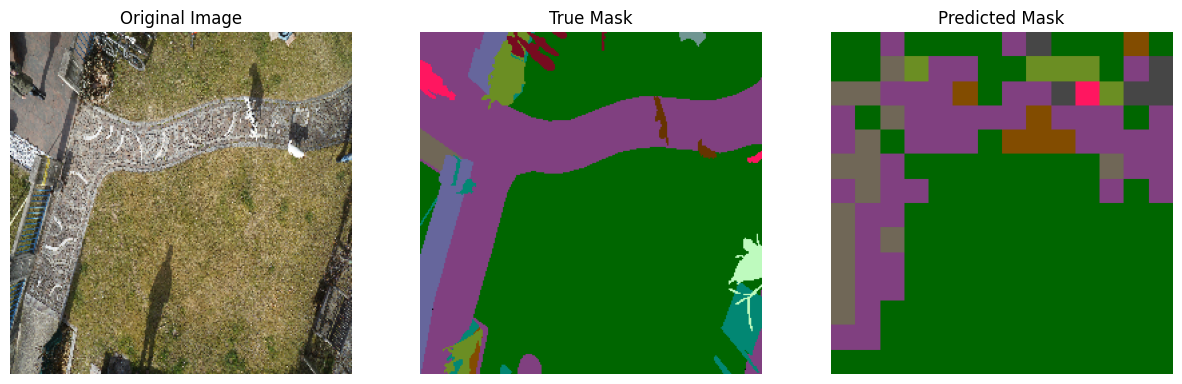

---------------------------------------------------------------------------------------